In [1]:
#from google.colab import drive

#drive.mount('/content/gdrive')

#import sys
#sys.path.append("/content/gdrive/MyDrive/QURIP-thompsonlab-amo/")

import numpy as np
import matplotlib.pyplot as plt
from ML_for_GreenImaging.PipelineStages import *
from tensorflow.keras import models, optimizers, layers, metrics
import keras
import tensorflow as tf

2023-07-09 22:40:26.316162: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 30ms"
#model = models.load_model(path + "/model1.h5")

In [3]:
loader = Loader.Loader(100, 20, path, path + "/model1.h5")
stack, tot_loops, info = loader.run()

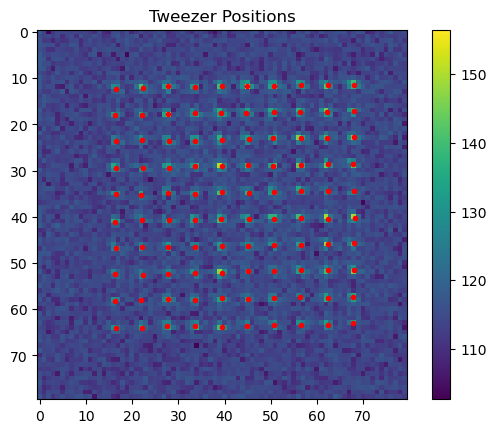

In [4]:
processor = ImageProcessing.ImageProcessor(stack, 100, tot_loops)
crops3x3, crops1x1, positions, info = processor.run()

In [5]:
crops = np.reshape(crops3x3, (-1, *crops3x3.shape[2:]))
crops = (crops - np.min(crops)) / np.max(crops)

In [55]:
latent_dim = 9
input_dims = crops.shape[1:]

def binary_regularizer(x):
    return 0.05 * tf.math.reduce_sum(0.5 - tf.math.abs(x - 0.5)) / 9

class Autoencoder(keras.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = keras.Sequential([
        layers.Input((*input_dims, 1)),
        layers.Conv2D(8, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(9, activation='sigmoid', activity_regularizer=binary_regularizer)
    ])
    self.decoder = keras.Sequential([
      layers.Input(9),
      layers.Dense(392, activation='sigmoid'),
      layers.Reshape((7, 7, 8)),
      layers.UpSampling2D((2, 2)),
      layers.Conv2DTranspose(8, (3, 3), activation='relu'),
      layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
    ])
    print(self.encoder.summary())
    print(self.decoder.summary())

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 14, 14, 8)         80        
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 7, 7, 8)          0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 392)               0         
                                                                 
 dense_29 (Dense)            (None, 9)                 3537      
                                                                 
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_31"
_________________________________________________________________
 Layer (type)          

In [60]:
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mae')

In [61]:
autoencoder.fit(crops, crops, epochs=2)

Epoch 1/2
 1046/48750 [..............................] - ETA: 6:11 - loss: 0.0211

KeyboardInterrupt: 

In [ ]:
# Things to test with this:
# 1. What do autoencoded images look like?
# 2. What do decoded images look like after user entry?
# 3. Bright to dark probability?
# 4. Does this work?

In [ ]:
autoencoded_crops = autoencoder.predict(crops)

48750/48750 [==============================] - 121s 2ms/step


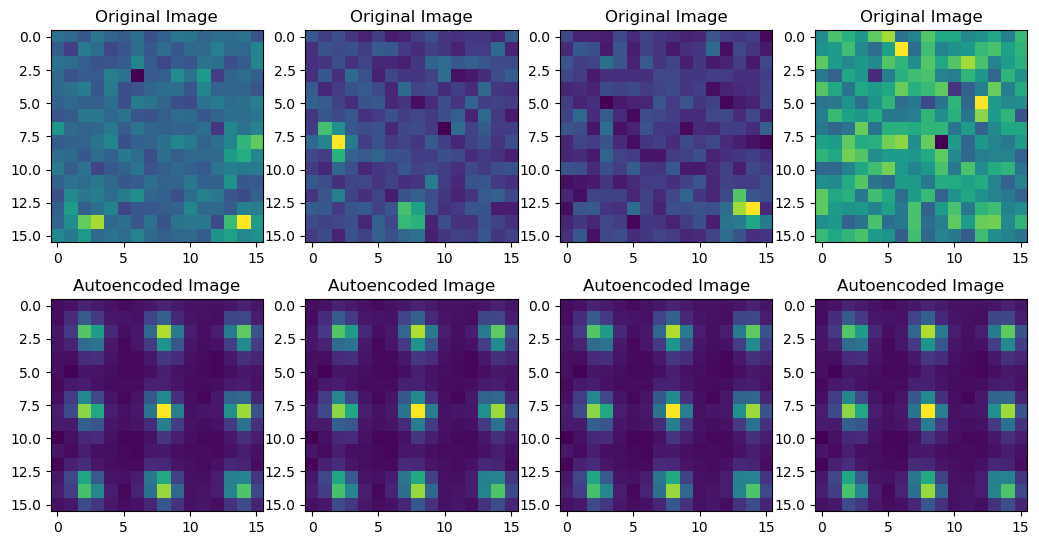

In [51]:
fig, axs = plt.subplots(2, 4, figsize=(12.6, 6.4))

for i in range(4):

    index = np.random.randint(crops.shape[0])

    axs[0, i].imshow(crops[index], norm='log')
    axs[0, i].set_title("Original Image")
    axs[1, i].imshow(autoencoded_crops[index], norm='log')
    axs[1, i].set_title("Autoencoded Image")

In [76]:
inputs = np.eye(9)

In [79]:
decoded = autoencoder.decoder.predict(-1 * inputs)

1/1 [==============================] - 0s 37ms/step


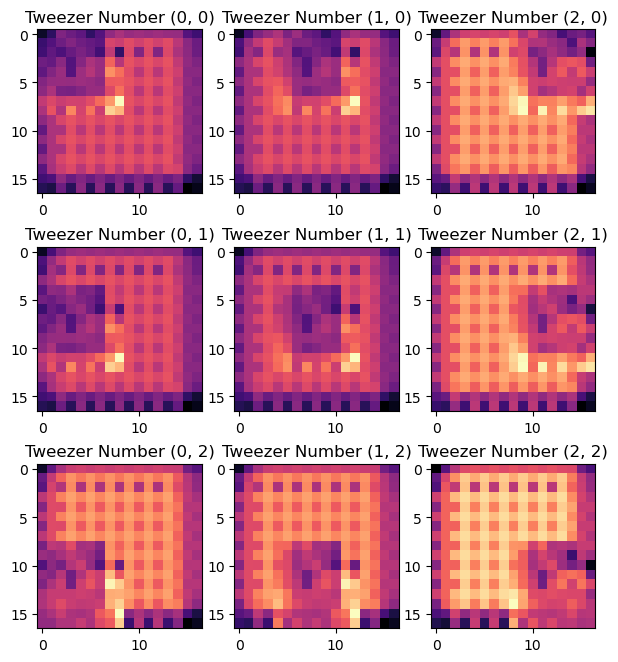

In [78]:
fig, axs = plt.subplots(3, 3, figsize=(7.2, 8))
for i in range(9):
    axs[i // 3][i % 3].imshow(decoded[i], cmap='magma')
    axs[i // 3][i % 3].set_title(f"Tweezer Number ({i % 3}, {i // 3})")


In [24]:
import matplotlib.colors as colors